In [1]:
import emcee

In [2]:
import fsps

In [3]:
import corner

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Problem 1

The error on Wikipedia is...

# Problem 2

## 2.1

In [12]:
#theta = (Mmin,Mmax,alpha)
theta_true = 0.1,10.0,-2.0
N = 100 #number of stars to generate
dm = 0.01 #distance between mass bins in model

def powerLaw(M,theta):
    return M**(theta[2])

def probDist(dm,theta):
    '''Normalized probability distribution of masses'''
    arr = np.arange(theta[0],theta[1],dm)
    prob = powerLaw(arr, theta)
    return arr,prob/np.sum(prob)

def sample_dist(N,dm,theta):
    arr, pd = probDist(dm,theta)
    stars = np.random.choice(arr,N,p=pd) #non-uniform random sample over the mass range, where pd is the prob. distribution
    return stars


In [14]:
stars = sample_dist(N,dm,theta_true)

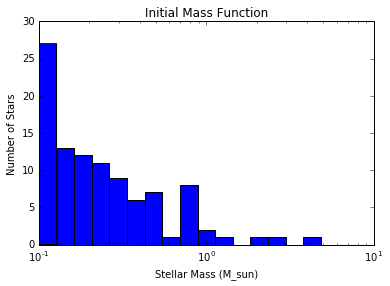

In [15]:
plt.hist(stars, bins=np.logspace(-1, 1, 20))
plt.gca().set_xscale("log")
plt.title('Initial Mass Function')
plt.xlabel('Stellar Mass (M_sun)')
plt.ylabel('Number of Stars')
plt.show()
    

## 2.2

In [ ]:
ndim, nwalkers = 3, 100

def lnlike(theta,stars):
    '''What to put here?'''
    return 

def lnprior(theta):
    '''Flat prior for now.'''
    if 0.05 < theta[0] < 0.2 and 5.0 < theta[1] < 100.0 and -5.0 < theta[2] < 0.0:
        return 0.0
    else:
        return -np.inf

def lnprob(theta,stars):
    return lnprior(theta) + lnlike(theta,stars)

#randomize initial position of walkers
p0 = [1e-2*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x,y,yerr))
sampler.run_mcmc(p0, 1000)

fig = corner.corner(sampler.flatchain, labels=['$M_low$', '$M_high$','alpha'])
plt.show()
